In [95]:
import numpy as np
import matplotlib.pyplot as plt

# HW 1 Code Below

In [96]:
def SIR(S0,I0,R0, beta, gamma, mu_birth, mu_death, t_max, stepsize, n_target=None):
    T = np.arange(0,t_max+stepsize,stepsize)
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    # N = S0+I0+R0 # This can't be constant if we are including births and deaths in the model
    
    for idx, t in enumerate(T):
        if idx==0:
            S[idx] = S0
            I[idx] = I0
            R[idx] = R0
        else:
            N = S[idx-1] + I[idx-1] + R[idx-1]
            if N <= 0:
                S[idx], I[idx], R[idx] = 0.0, 0.0, 0.0
                continue

            # The math here can be thought of as X_new = X_old + dX_dt * dt
            dS_dt = -beta * S[idx-1] * I[idx-1] / N + mu_birth * N - mu_death * S[idx-1]
            dI_dt = beta * S[idx-1] * I[idx-1] / N - gamma * I[idx-1] - mu_death * I[idx-1]
            dR_dt = gamma * I[idx-1] - mu_death * R[idx-1]
            
            S[idx] = max(S[idx-1] + dS_dt * stepsize, 0.0)
            I[idx] = max(I[idx-1] + dI_dt * stepsize, 0.0)
            R[idx] = max(R[idx-1] + dR_dt * stepsize, 0.0)

            # Stop once N crosses the target, and return trimmed arrays
            # if n_target is not None:
            #     N_now = S[idx] + I[idx] + R[idx]
            #     if N_now >= n_target:
            #         cut = idx + 1
            #         return S[:cut], I[:cut], R[:cut], T[:cut]
            # return S, I, R, T
    
    return S, I, R, T

(0.0, 157.5)

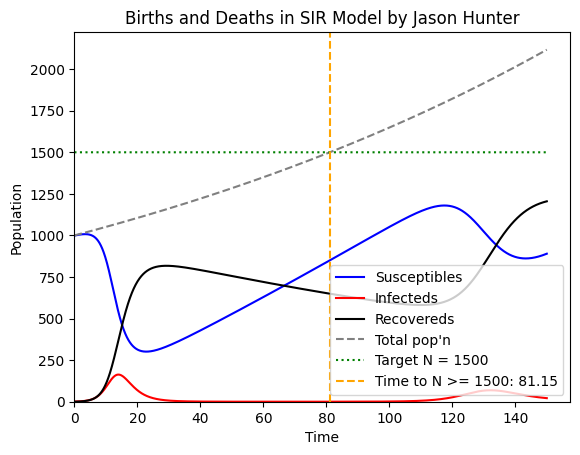

In [97]:
# Parameters:
S0 = 999
I0 = 1
R0 = 0
beta = 1
gamma = 0.5
mu_birth = 0.01
mu_death = 0.5 * mu_birth  # = 0.005
t_max = 150
stepsize = 0.05
n_target = 1500  # Stop sim if pop'n exceeds this

S,I,R,T = SIR(S0,I0,R0,
              beta, gamma,
              mu_birth, mu_death,
              t_max, stepsize, n_target)

fig, ax = plt.subplots()
ax.plot(T,S, color='b', label='Susceptibles')
ax.plot(T,I, color='r', label='Infecteds')
ax.plot(T,R, color='k', label='Recovereds')

N = S + I + R
ax.plot(T,N, color='gray', linestyle='--', label='Total pop\'n')

n_target = np.full(len(T), n_target)
ax.plot(T,n_target, color='green', linestyle=':', label='Target pop\'n')

time_to_target = T[np.where(N >= n_target)[0][0]] if np.any(N >= n_target) else None
if time_to_target is not None:
    ax.axvline(x=time_to_target, color='orange', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend(['Susceptibles', 'Infecteds', 'Recovereds', 'Total pop\'n', 'Target N = 1500', 'Time to N >= 1500: {}'.format(time_to_target)])
ax.set_title('Births and Deaths in SIR Model by Jason Hunter')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

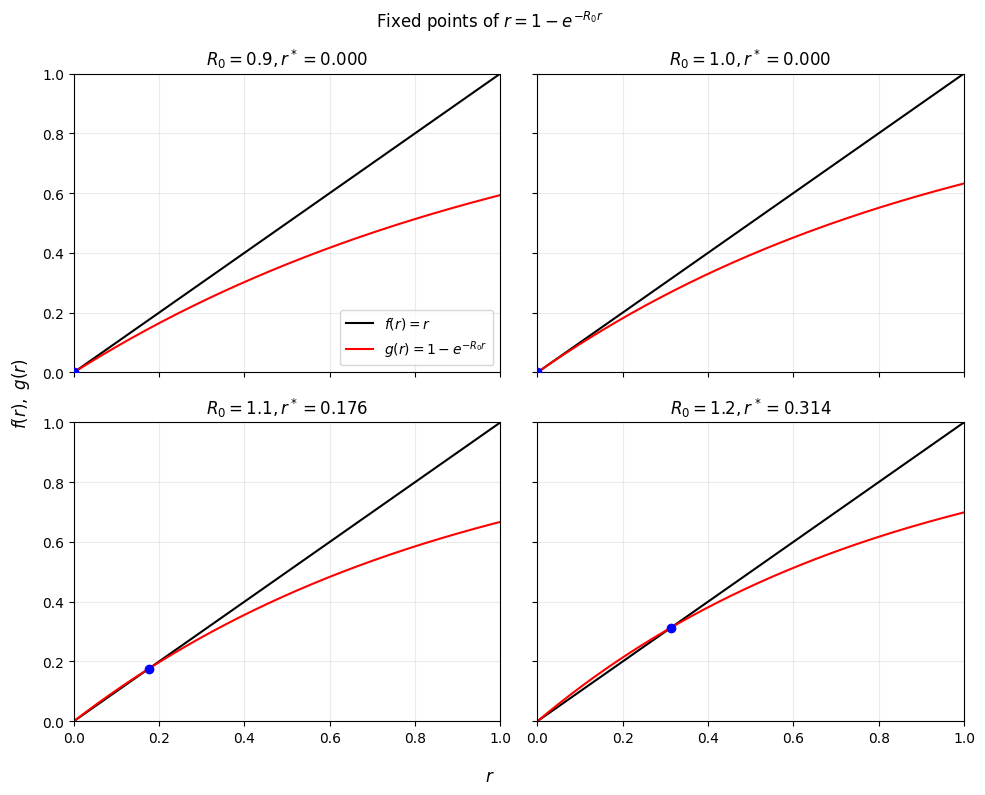

In [98]:
from scipy.optimize import fsolve, brentq

def h_x_factory(R0):
    """Returns a function h(x) = x - (1 - exp(-R0 * x))
    such that the root of h(x) gives the final size of an epidemic
    in a standard SIR model without births and deaths.

    Args:
        R0 (float): The basic reproduction number.

    Returns:
        function: A function that computes h(x).
    """
    return lambda x: x - (1 - np.exp(-R0 * x))

def find_root(R0):
    """Finds the root of h(x) = x - (1 - exp(-R0 * x)) using fsolve.
    h(x) is basically f(x) - g(x) where f(x) = x and g(x) = 1 - exp(-R0 * x).
    The root of h(x) gives the final size of an epidemic in a standard SIR
    model without births and deaths.
    
    Args:
        R0 (float): The basic reproduction number.

    Returns:
        float: The final size of the epidemic.
    """
    if R0 <= 1:
        return 0.0  # No epidemic occurs if R0 <= 1
    h_x = h_x_factory(R0)
    eps = 1e-8  # tiny positive number to avoid the trivial root at 0
    return float(brentq(h_x, eps, 1.0 - eps))  # h(eps)<0 and h(1)>0 for R0>1

R0_list = [0.9,1.0,1.1,1.2]
r = np.linspace(0,1,1000)

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
for ax, R0 in zip(axs.flatten(), R0_list):
    f_vals = r
    g_vals = 1 - np.exp(-R0 * r)
    ax.plot(r, f_vals, label=r'$f(r) = r$', color = 'k')
    ax.plot(r, g_vals, label=r'$g(r) = 1 - e^{-R_0 r}$', color = 'r')
    r_star = find_root(R0)
    ax.scatter([r_star], [r_star], color='blue', zorder=5)
    ax.set_title(fr'$R_0 = {R0}, r^* = {r_star:.3f}$')
    
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid(True, alpha = 0.25)
    
axs.flat[0].legend(loc='lower right')
fig.suptitle(r'Fixed points of $r = 1 - e^{-R_0 r}$')
fig.supxlabel(r'$r$')
fig.supylabel(r'$f(r),\ g(r)$')
plt.tight_layout()
plt.show()

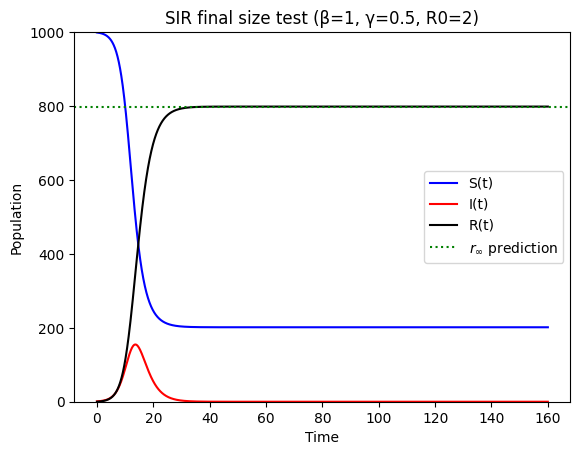

Theoretical r_infty fraction: 0.7968


In [99]:
beta = 1.0
gamma = 0.5
mu_birth = 0.0
mu_death = 0.0

S0 = 999
I0 = 1
R0 = 0
N = S0 + I0 + R0

t_max = 160
stepsize = 0.05

S, I, R, T = SIR(S0, I0, R0,
                 beta, gamma,
                 mu_birth, mu_death,
                 t_max, stepsize)

R0_epidemic = beta/gamma
r_star = find_root(R0_epidemic)
r_infinity = r_star * N  # Convert from fraction to number of people

fig, ax = plt.subplots()
ax.plot(T, S, color='b', label='S(t)')
ax.plot(T, I, color='r', label='I(t)')
ax.plot(T, R, color='k', label='R(t)')
ax.axhline(y=r_infinity, color='g', linestyle=':', label=r'$r_\infty$ prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('SIR final size test (β=1, γ=0.5, R0=2)')
ax.legend()
ax.set_ylim(bottom=0, top=N)
plt.show()

print(f'Theoretical r_infty fraction: {r_star:.4f}')



# HW 2 Code Below

In [100]:
def SIS(i0, beta, gamma, t_max, dt):
    # di/dt = (beta - gamma) i - i * beta^2, normalized (s + i = 1)
    steps = int(np.floor(t_max/dt))
    T = np.arange(0,steps + 1, dtype=float) * dt
    I = np.zeros(steps+1, dtype=float)
    I[0] = i0
    for n in range(steps):
        dI = (beta - gamma) * I[n] - beta * (I[n] ** 2)
        I[n+1] = I[n] + dt * dI
        # bound to the range [0,1] to ensure numerical stability
        I[n+1] = min(1.0, max(0.0, I[n+1]))
    return T, I

T, I = SIS(0.01, 3.0, 2.0, 25.0, 2.0)
print(T, I)

def SIS_analytical(t, beta, gamma, i0):
    # Logistic closed form: i(t) = K/ 1 + ((K - I0)/I0) e^{-r t}), r = beta-gamma, K=r/beta
    r = beta - gamma
    K = r /beta
    return K / (1.0 + ((K-i0)/ i0) * np.exp(-r * t))

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24.] [0.01       0.0294     0.08301384 0.20769373 0.36426108 0.29666643
 0.36193346 0.2998254  0.36010458 0.30226189 0.35861217 0.30422038
 0.3573609 ]


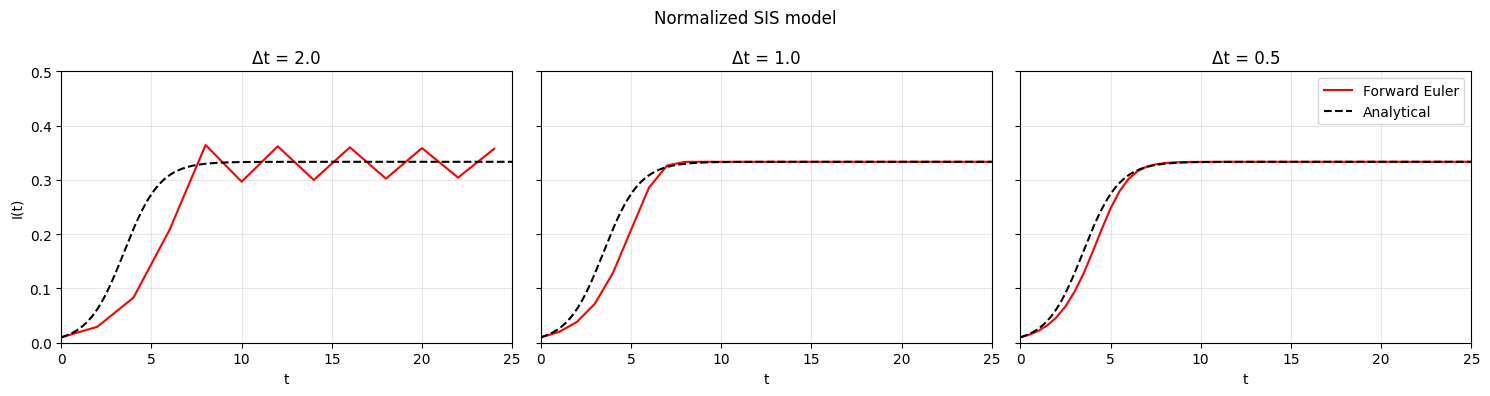

In [101]:
beta, gamma = 3.0, 2.0
s0,i0 = 0.99, 0.01
t_max = 25.0
dts = [2.0, 1.0, 0.5]

t_dense = np.linspace(0.0, t_max, 500)
I_exact = SIS_analytical(t_dense, beta, gamma, i0)

fig, axes = plt.subplots(1,3, figsize=(15,4), sharey = True)
for ax,dt in zip(axes,dts):
    T, I_num = SIS(i0, beta, gamma, t_max, dt)
    ax.plot(T, I_num,'r-', label = 'Forward Euler')
    ax.plot(t_dense, I_exact, 'k--', label = 'Analytical')
    ax.set_xlim(0, t_max)
    ax.set_ylim(0, 0.5)
    ax.set_title(f'Δt = {dt}')
    ax.set_xlabel('t')
    ax.grid(True, alpha =0.3)

axes[0].set_ylabel('I(t)')
axes[-1].legend(loc='upper right')
fig.suptitle('Normalized SIS model')
fig.tight_layout()
plt.show()

## Max Absolute Error for Problem 1C

In [102]:
def max_abs_error(dt, t_max, beta, gamma, i0):
    T, I_num = SIS(i0 = i0, beta=beta, gamma=gamma, t_max = t_max, dt=dt)
    I_exact = SIS_analytical(T, beta = beta, gamma=gamma, i0=i0)
    return float(np.max(np.abs(I_num - I_exact)))

errors: [0.12633934988700748, 0.0807710743745694, 0.04283504637204702, 0.021997720425787404, 0.011110659764940994, 0.005580919660415989, 0.002795846918956929]


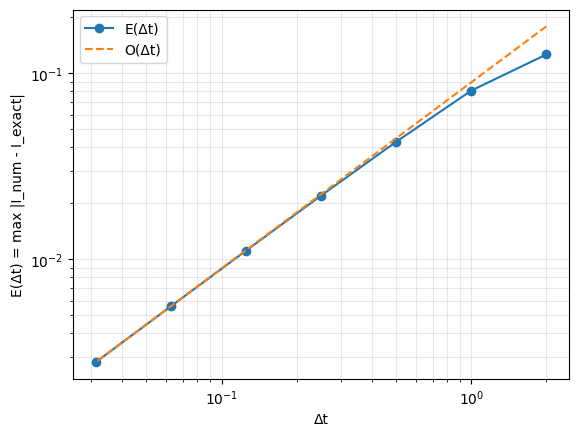

Estimated order p ≈ 0.93


In [103]:
# E(Δt) vs Δt on log-log axes + estimated order
dts = [2.0, 1.0, 0.5, 0.25, 0.125, 1/16, 1/32]
errors = [max_abs_error(dt, 25.0, 3.0, 2.0, 0.01) for dt in dts]
print("errors:", errors)

plt.figure()
plt.loglog(dts, errors, 'o-', label='E(Δt)')

# Reference O(Δt) line anchored at smallest Δt
dts_np = np.array(dts, dtype=float)
k = errors[-1] / dts_np[-1]
plt.loglog(dts_np, k * dts_np, '--', label='O(Δt)')

plt.xlabel('Δt')
plt.ylabel('E(Δt) = max |I_num - I_exact|')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()

# Optional: estimated order p from linear fit in log-log
p = np.polyfit(np.log(dts_np), np.log(errors), 1)[0]
print(f"Estimated order p ≈ {p:.2f}")

# HW 3 Code Below

R0_check = 1.500


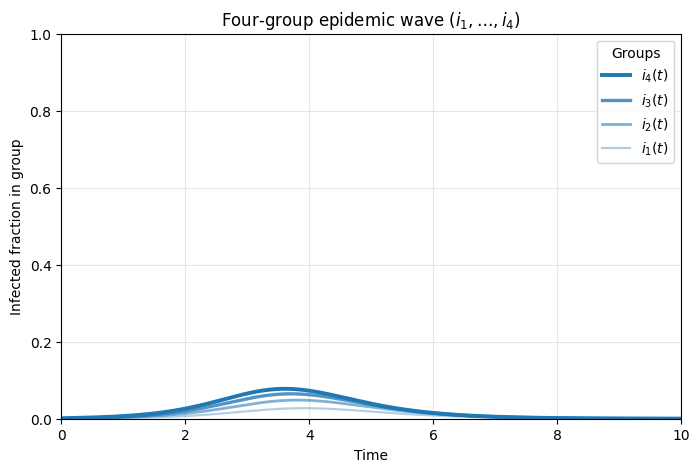

In [104]:
# 4-group SIR with group-specific susceptibility and homogeneous mixing

def simulate_multigroup_SIR(beta, gamma, sigma, dt, t_max, i0=0.001, weights=None, mixing=None):
    """
    Multi-group SIR with group-specific susceptibility (sigma).
    - i_k are fractions within each group (0..1).
    - Force of infection on group k: lambda_k = beta * sigma_k * sum_j (mixing[k,j] * w_j * i_j)
      With homogeneous mixing (default), mixing[k,j] = 1 for all k,j.
    - weights w_j are group population shares (default equal).
    """
    sigma = np.asarray(sigma, dtype=float)
    G = sigma.size

    if weights is None:
        weights = np.ones(G, dtype=float) / G
    else:
        weights = np.asarray(weights, dtype=float)
        weights = weights / np.sum(weights)

    if mixing is None:
        mixing = np.ones((G, G), dtype=float)
    else:
        mixing = np.asarray(mixing, dtype=float)
        assert mixing.shape == (G, G), "mixing must be GxG"

    steps = int(np.ceil(t_max / dt))
    T = np.arange(steps + 1) * dt

    s = np.full((G, steps + 1), 1.0 - i0, dtype=float)  # susceptible fraction per group
    i = np.full((G, steps + 1), i0, dtype=float)        # infected fraction per group
    r = np.zeros((G, steps + 1), dtype=float)           # recovered fraction per group

    for n in range(steps):
        # Weighted infectious prevalence vector (w_j * i_j)
        wi = weights * i[:, n]
        # Mixing-weighted infectious pressure on each group
        I_pressure = mixing @ wi  # shape (G,)
        lam = beta * sigma * I_pressure

        new_inf = dt * lam * s[:, n]
        recov = dt * gamma * i[:, n]

        s[:, n + 1] = s[:, n] - new_inf
        i[:, n + 1] = i[:, n] + new_inf - recov
        r[:, n + 1] = r[:, n] + recov

        # numerical safety
        s[:, n + 1] = np.clip(s[:, n + 1], 0.0, 1.0)
        i[:, n + 1] = np.clip(i[:, n + 1], 0.0, 1.0)
        r[:, n + 1] = np.clip(r[:, n + 1], 0.0, 1.0)

    return T, s, i, r

beta = 1.8      # base transmission rate (IDK if this is right tbh)
gamma = 3.0
sigma = np.array([1.0, 2.0, 3.0, 4.0])  # most -> least susceptible

# Quick check: R0
R0_check = (beta/gamma) * (sigma.mean())
print(f"R0_check = {R0_check:.3f}")


# Simulation controls (captures 1 full wave)
dt = 0.01
t_max = 10.0

T, Sg, Ig, Rg = simulate_multigroup_SIR(beta, gamma, sigma, dt, t_max, i0=0.001)

# Plot i1(t)..i4(t) in a single hue, darkest = most susceptible
fig, ax = plt.subplots(figsize=(8,5))

order = np.argsort(sigma)[::-1]  # descending susceptibility (4 is darkest)
alphas = np.linspace(1.0, 0.35, len(sigma))  # darkest to lightest
base_color = 'tab:blue'
for rank, k in enumerate(order):
    ax.plot(T, Ig[k, :], color=base_color, alpha=alphas[rank],
            linewidth=2.8 - 0.4*rank, label=fr"$i_{{{k+1}}}(t)$")

ax.set_xlabel("Time")
ax.set_ylabel("Infected fraction in group")
ax.set_title(r"Four-group epidemic wave ($i_{1},\ldots,i_{4}$)")
ax.set_xlim(0, t_max)
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(title="Groups", loc="upper right")
plt.show()

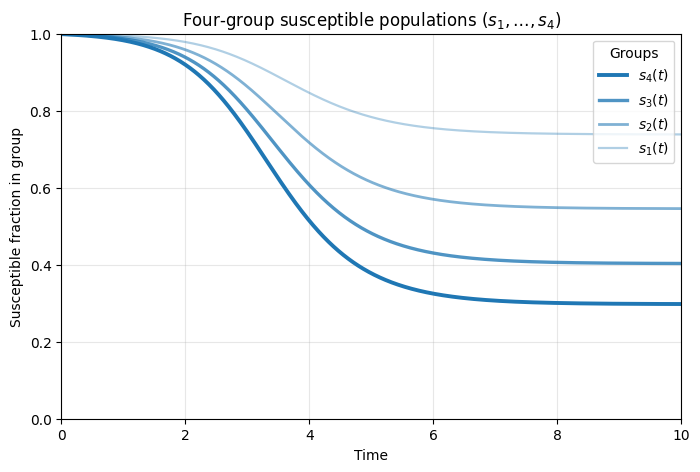

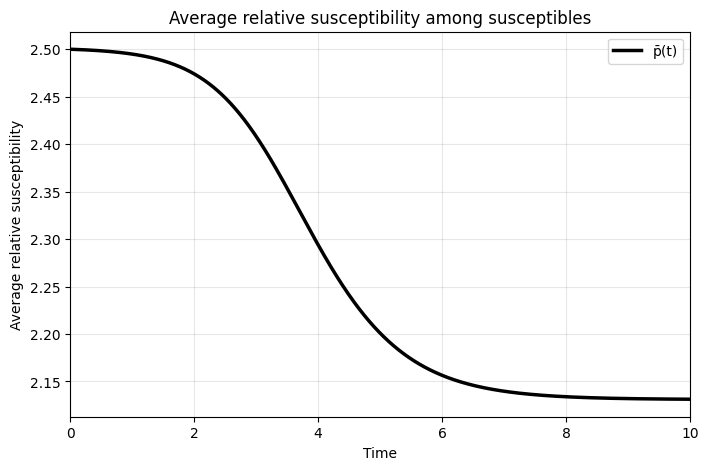

In [105]:
# Plot si(t) for each group using the same color scheme
fig, ax = plt.subplots(figsize=(8,5))

order = np.argsort(sigma)[::-1]  # descending susceptibility (4 is darkest)
alphas = np.linspace(1.0, 0.35, len(sigma))  # darkest to lightest
base_color = 'tab:blue'
for rank, k in enumerate(order):
    ax.plot(T, Sg[k, :], color=base_color, alpha=alphas[rank],
            linewidth=2.8 - 0.4*rank, label=fr"$s_{{{k+1}}}(t)$")

ax.set_xlabel("Time")
ax.set_ylabel("Susceptible fraction in group")
ax.set_title(r"Four-group susceptible populations ($s_{1},\ldots,s_{4}$)")
ax.set_xlim(0, t_max)
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(title="Groups", loc="upper right")
plt.show()

# Calculate p̄(t) - average relative susceptibility among susceptibles
num = sigma @ Sg
den = Sg.sum(axis=0)
p_bar = np.divide(num, den, out=np.zeros_like(num), where=den>0)

# Plot p̄(t) in black
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(T, p_bar, color='black', linewidth=2.5, label="p̄(t)")
ax.set_xlabel("Time")
ax.set_ylabel("Average relative susceptibility")
ax.set_title("Average relative susceptibility among susceptibles")
ax.set_xlim(0, t_max)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# np.isclose(p_bar[0], sigma.mean())  # validation check

Text(0, 0.5, 'frequency')

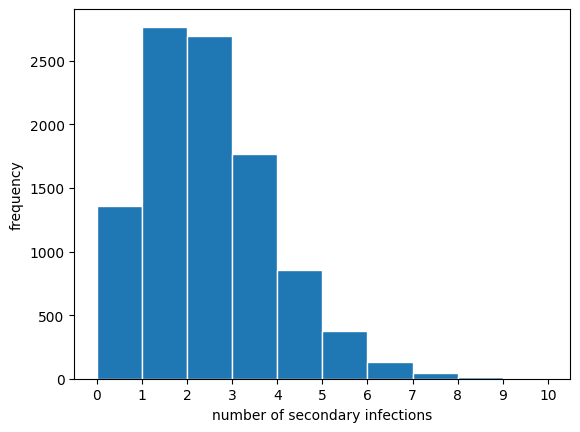

In [106]:
R0 = 2
fig,ax = plt.subplots()
draws = np.random.poisson(R0,10000)
num_bins = np.arange(np.max(draws)+1)
ax.hist(draws,edgecolor='w',bins=num_bins)
ax.set_xticks(num_bins)
ax.set_xlabel('number of secondary infections')
ax.set_ylabel('frequency')

In [107]:
def n_children_poisson(R0,n_draws):
    draws = np.random.poisson(R0,size=n_draws)
    total_children = np.sum(draws)
    return total_children

In [108]:
def sample_BP(children_function, R0, n_generations):
    z = np.zeros(n_generations, dtype=int)
    z[0] = 1
    for generation in np.arange(1,n_generations):
        z[generation] = children_function(R0,z[generation-1])
    return z

In [109]:
sample_BP(n_children_poisson, 2, 10)

array([  1,   2,   5,  11,  27,  56, 107, 225, 481, 963])

Text(0, 0.5, 'branching process size')

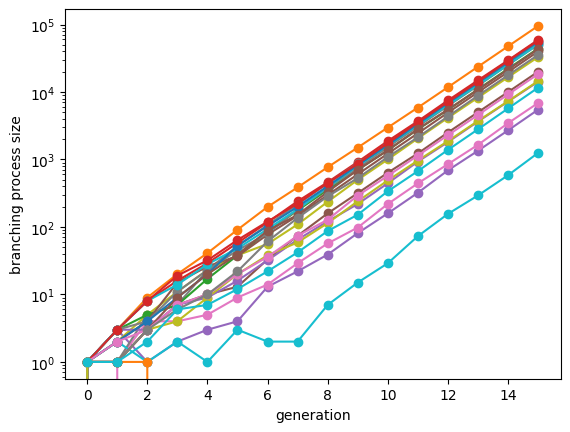

In [110]:
fig,ax = plt.subplots()

for i in range(30):
    trajectory = sample_BP(n_children_poisson,2,16)
    ax.semilogy(trajectory,'-o')
    
ax.set_xlabel('generation')
ax.set_ylabel('branching process size')

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import brentq
from typing import Tuple, List

# PGF for NB(R0, k): G(s) = (1 + (R0/k)*(1 - s))^(-k)
def extinction_prob_nb(R0: float, k: float) -> float:
    if R0 <= 1.0:
        return 1.0
    a = R0 / k
    def G(q): return (1.0 + a * (1.0 - q)) ** (-k)
    def f(q): return q - G(q)
    # find the nontrivial root in (0, 1)
    return brentq(f, 0.0, 1.0 - 1e-12)

# one simulation run; returns (extinct, total_outbreak_size)
def simulate_run(R0: float, k: float, rng: np.random.Generator,
                 max_gen: int = 1000, max_total: int = 100_000) -> Tuple[bool, int]:
    # SciPy parameterization: n = k, p = k/(k+R0); sum over m individuals -> NB(n = m*k, p)
    p = k / (k + R0)
    current = 1
    total = 1
    gen = 0
    while current > 0 and gen < max_gen and total <= max_total:
        # draw total offspring from all current individuals in one NB call
        next_gen = int(nbinom.rvs(n=current * k, p=p, random_state=rng))
        current = next_gen
        total += current
        gen += 1
    return (current == 0), total

def estimate_q(R0: float, k: float, n_sims: int = 100_000, seed: int = 42,
               max_gen: int = 1000, max_total: int = 100_000) -> float:
    rng = np.random.default_rng(seed)
    extinct_count = 0
    for _ in range(n_sims):
        extinct, _ = simulate_run(R0, k, rng, max_gen=max_gen, max_total=max_total)
        extinct_count += int(extinct)
    return extinct_count / n_sims

def sample_finite_outbreak_sizes(R0: float, k: float, n_sims: int = 100_000, seed: int = 123,
                                 max_gen: int = 1000, max_total: int = 100_000) -> List[int]:
    rng = np.random.default_rng(seed)
    sizes = []
    for _ in range(n_sims):
        extinct, total = simulate_run(R0, k, rng, max_gen=max_gen, max_total=max_total)
        if extinct:
            sizes.append(total)
    return sizes

def main():
    R0 = 3.0
    ks = [0.1, 0.5, 1.0, 5.0, 10.0]
    n_sims = 100_000

    print("k\tq_sim\tq_exact")
    for k in ks:
        q_exact = extinction_prob_nb(R0, k)
        q_sim = estimate_q(R0, k, n_sims=n_sims, seed=2025)
        print(f"{k}\t{q_sim:.3f}\t{q_exact:.3f}")

    # histograms of finite outbreak sizes
    # using just k vals of 0.1, 1.0, 10.0
    ks_for_hist = [0.1, 1.0, 10.0]
    for k in ks_for_hist:
        sizes = sample_finite_outbreak_sizes(R0, k, n_sims=n_sims, seed=7)
        if not sizes:
            continue
        plt.figure(figsize=(6,4))
        # max_bin is a capped range for better histograms
        max_bin = min(50, max(sizes))
        bins = np.arange(1, max_bin + 2) - 0.5
        plt.hist(sizes, bins=bins, density=True, color="#4C72B0", edgecolor="white")
        plt.xlabel("Finite outbreak size (total cases)")
        plt.ylabel("Probability density")
        plt.title(f"Finite outbreak sizes, R0={R0}, k={k}")
        plt.tight_layout()
        plt.savefig(f"finite_outbreak_hist_R0{R0}_k{k}.png", dpi=200)
        plt.close()

if __name__ == "__main__":
    main()

k	q_sim	q_exact
0.1	0.838	0.838
0.5	0.500	0.500
1.0	0.334	0.333
5.0	0.121	0.120
10.0	0.089	0.089
